# 5-BIT Quantum error correction
This is an alternate encoding that we generated using a different set of operators. They generate a different set of codewords that also perform QEC in the same way as our initial encoding.  
Since we change our operators, the encoding, codewords and error syndrome also change.  
We have implemented the circuit corresponding to this encoding scheme as seen below.

In [ ]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
from math import pi
from qiskit.quantum_info import Statevector
import numpy as np

from qiskit.circuit.library.standard_gates import IGate, HGate
from qiskit.circuit.library import MCMT

In [ ]:
sim = Aer.get_backend('aer_simulator')

# Alternate encoding:
We use the following operators to encode our qubits:  
$$M_0=X_0X_3Z_1Z_2$$
$$M_1=X_1X_4Z_2Z_3$$
$$M_2=X_0X_2Z_3Z_4$$
$$M_3=X_1X_3Z_0Z_4$$

Encoded logic bits are as follows:
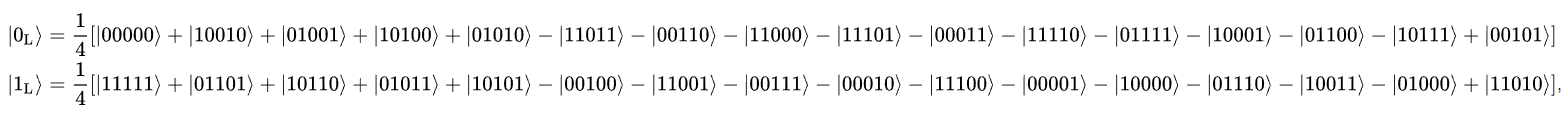


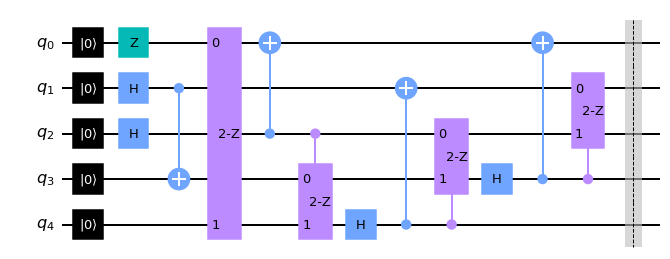

In [ ]:
# Encoding
qc_5q = QuantumCircuit(5)
qc_5q.reset(range(5))

cz2 = MCMT('cz', 1, 2)

qc_5q.z(0)

qc_5q.h(1)
qc_5q.cx(1, 3)
#qc_5q.cz(1, 2)
#qc_5q.cz(1, 4)
qc_5q.compose(cz2, qubits=[1, 0, 4], inplace=True)

qc_5q.h(2)
qc_5q.cx(2, 0)
#qc_5q.cz(4, 1)
#qc_5q.cz(4, 3)
qc_5q.compose(cz2, qubits=[2, 3, 4], inplace=True)

qc_5q.h(4)
qc_5q.cx(4, 1)
#qc_5q.cz(3, 0)
#qc_5q.cz(3, 2)
qc_5q.compose(cz2, qubits=[4, 2, 3], inplace=True)

qc_5q.h(3)
qc_5q.cx(3, 0)
#qc_5q.cz(2, 1)
#qc_5q.cz(2, 4)
qc_5q.compose(cz2, qubits=[3, 1, 2], inplace=True)

qc_5q.barrier()
qc_5q.draw('mpl')

In [ ]:
# Adding error
def apply_err(n, err):
  qc = QuantumCircuit(int(n), name='Error')
  which_qubit = np.random.randint(n)

  if err=='bit':
    qc.x(which_qubit)

  elif err=='pahse':
    qc.z(which_qubit)

  elif err=='bit+phase':
    qc.x(which_qubit)
    qc.z(which_qubit)

  else:
    pass

  err = qc.to_gate()

  return err, which_qubit

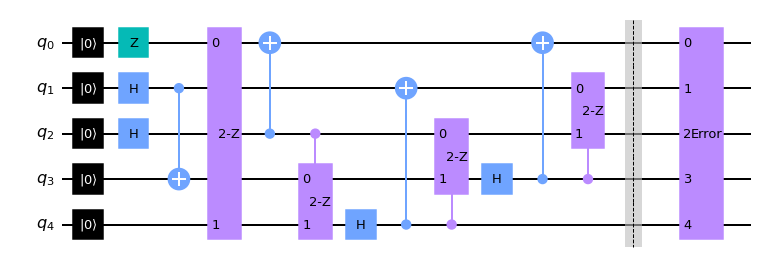

In [ ]:
err, which_qubit = apply_err(5, 'bit')

qc_5q.append(err, range(5))
qc_5q.draw('mpl')

In [ ]:
# Adding auxiliary & syndrome bits for error correction
qc_5q.add_register(QuantumRegister(4, 'auxiliary'))
qc_5q.add_register(ClassicalRegister(4, 'syndrome'))

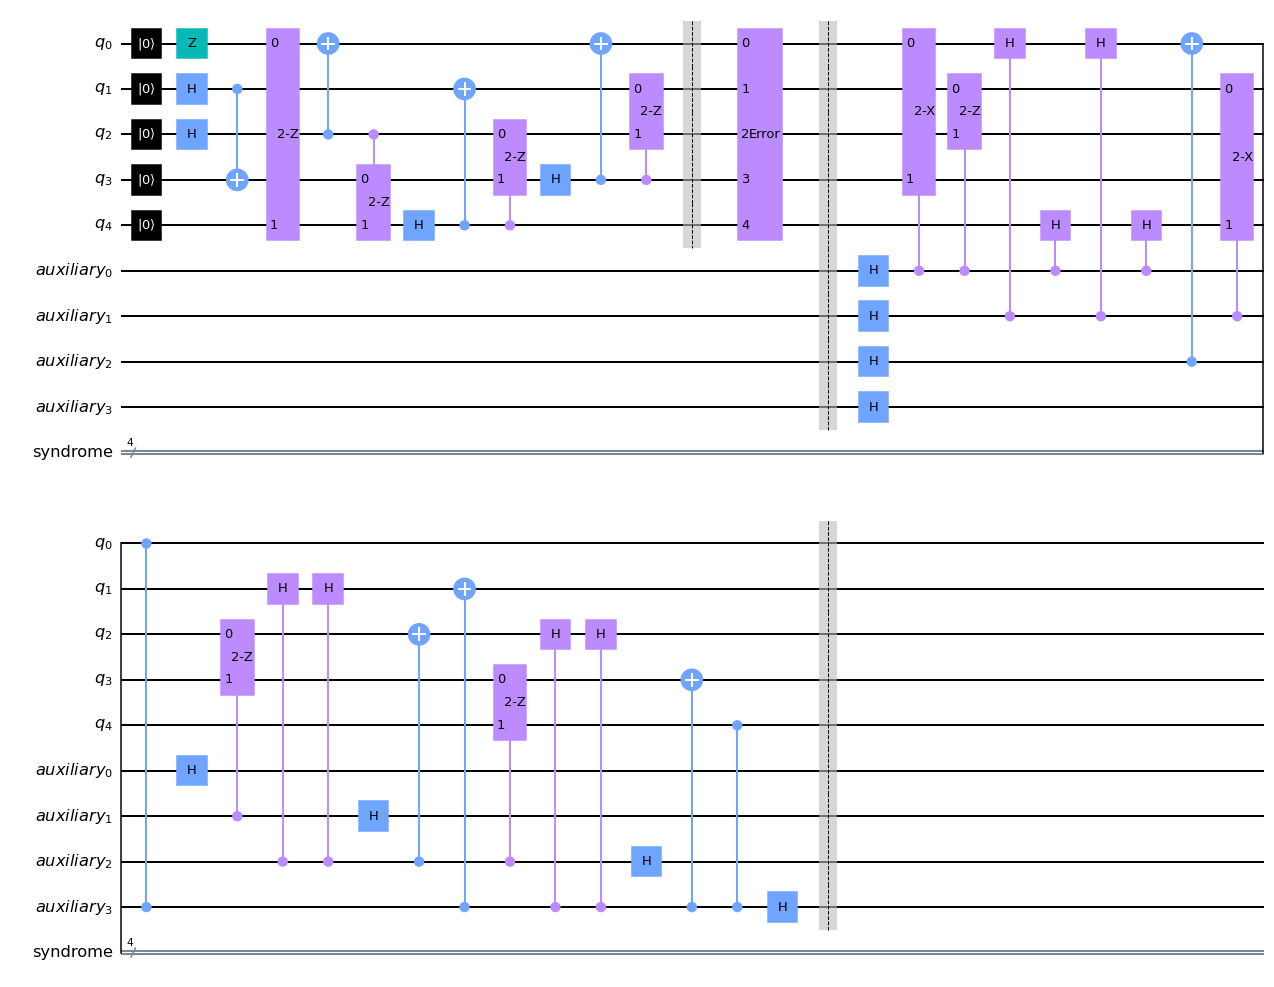

In [ ]:
# Syndrome Detection
qc_5q.barrier()
c_z2 = MCMT('cz', 1, 2)
c_x2 = MCMT('cx', 1, 2)

for i in range(4):
  qc_5q.h(5+i)

#qc_5q.cx(5, 2)
#qc_5q.cx(5, 3)
qc_5q.compose(c_x2, qubits=[5, 0, 3], inplace=True)
qc_5q.compose(c_z2, qubits=[5, 1, 2], inplace=True)
qc_5q.ch(5, 4)
qc_5q.ch(5, 4)

#qc_5q.cx(6, 3)
#qc_5q.cx(6, 4)
qc_5q.ch(6, 0)
qc_5q.ch(6, 0)
qc_5q.compose(c_x2, qubits=[6, 1, 4], inplace=True)
qc_5q.compose(c_z2, qubits=[6, 2, 3], inplace=True)

qc_5q.cx(7, 0)
qc_5q.ch(7, 1)
qc_5q.ch(7, 1)
qc_5q.cx(7, 2)
#qc_5q.compose(c_x2, qubits=[7, 0, 2], inplace=True)
qc_5q.compose(c_z2, qubits=[7, 3, 4], inplace=True)

qc_5q.cz(8, 0)
qc_5q.cx(8, 1)
qc_5q.ch(8, 2)
qc_5q.ch(8, 2)
qc_5q.cx(8, 3)
qc_5q.cz(8, 4)
#qc_5q.compose(c_x2, qubits=[8, 1, 3], inplace=True)
#qc_5q.compose(c_z2, qubits=[8, 0, 4], inplace=True)

for i in range(4):
  qc_5q.h(5+i)

qc_5q.barrier()
qc_5q.draw('mpl')

# Error Correction
We use the below syndrome and error operation:  
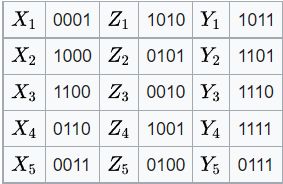

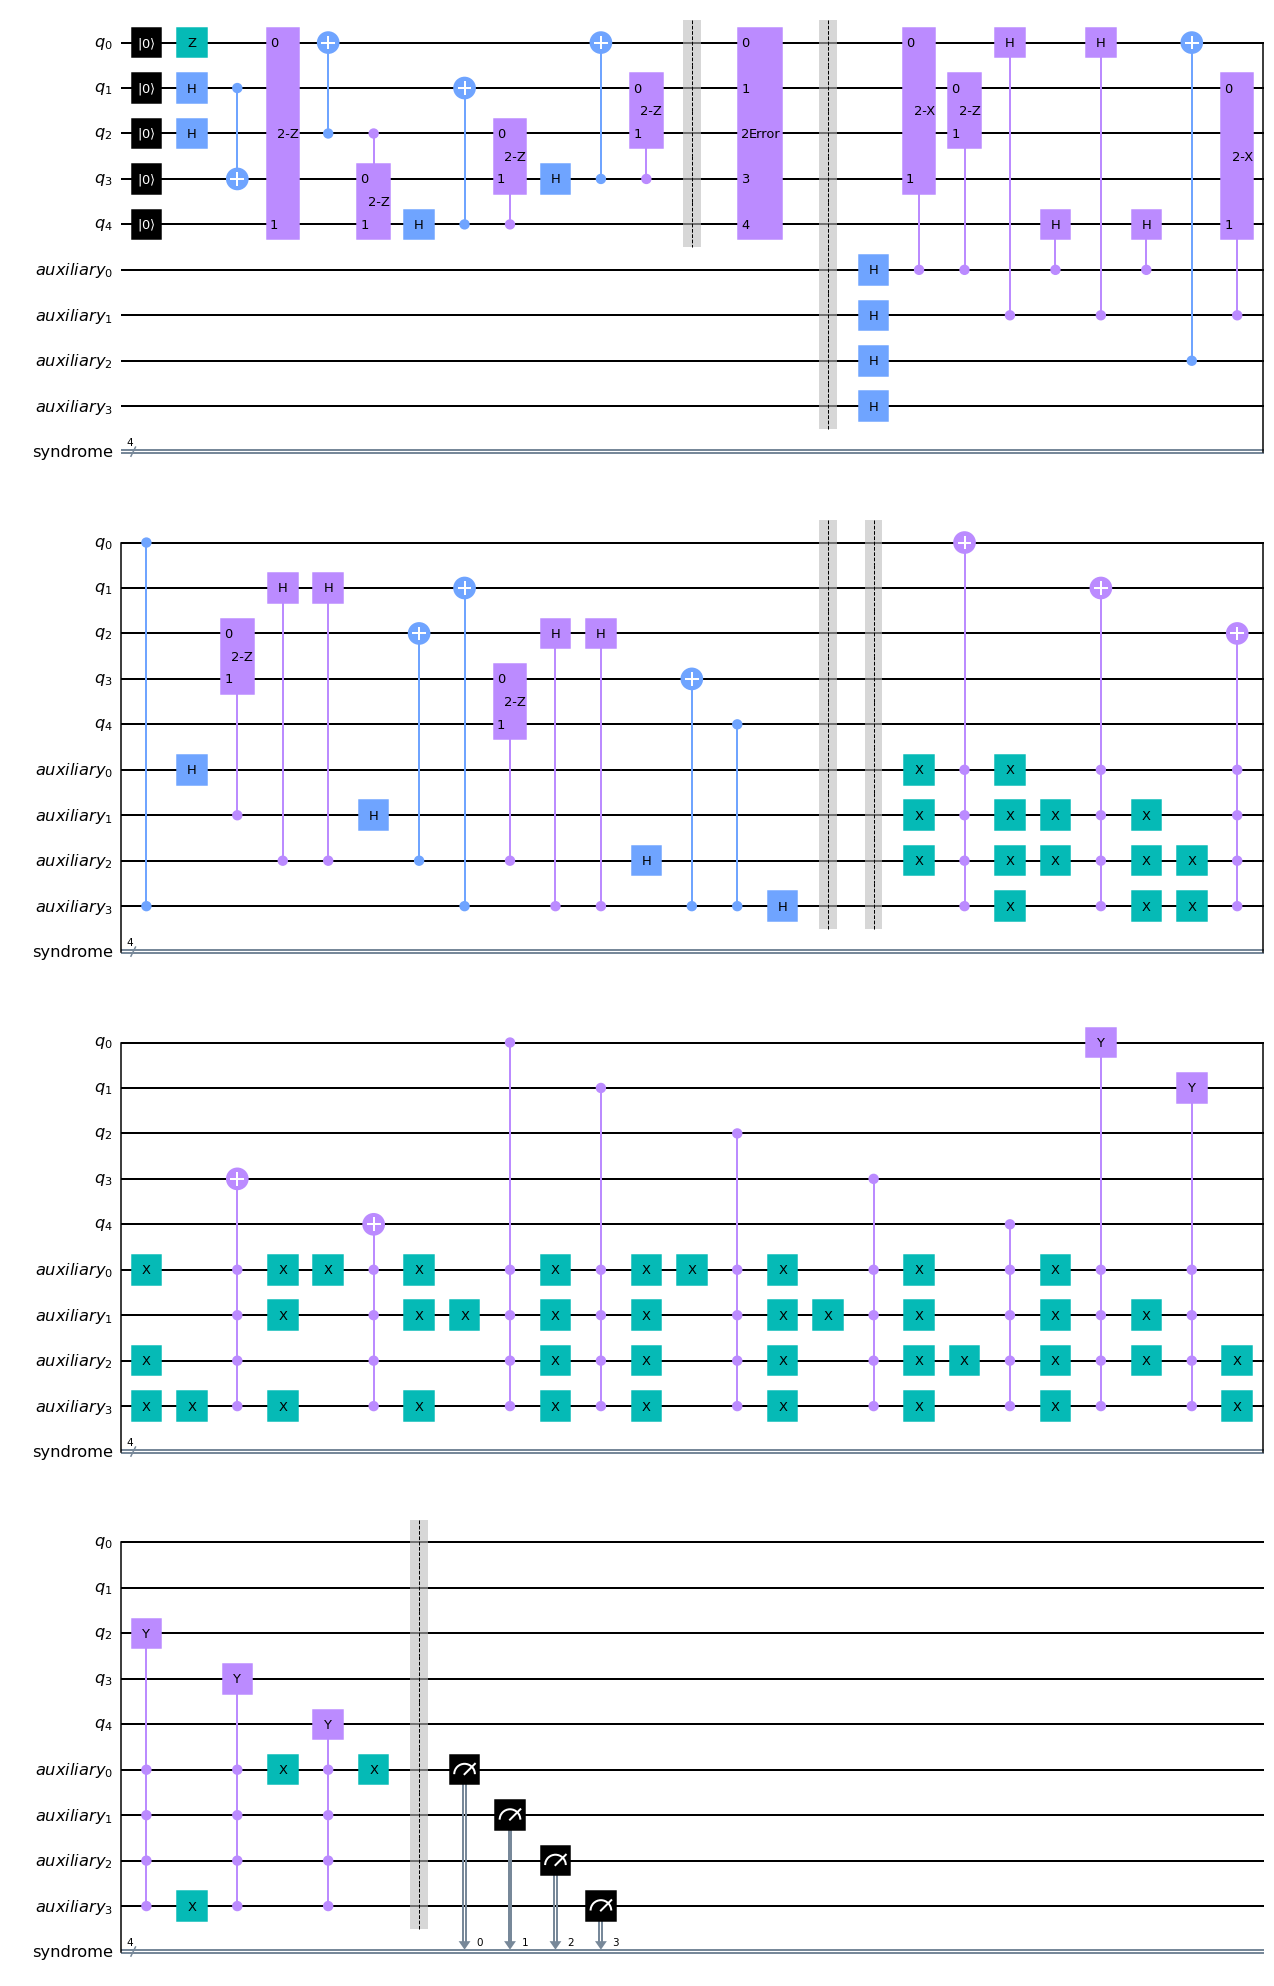

In [ ]:
# Error correction
qc_5q.barrier()
cx4 = MCMT('cx', 4, 1)
cz4 = MCMT('cz', 4, 1)
cy4 = MCMT('cy', 4, 1)

#x0 - 0001
qc_5q.x(5)
qc_5q.x(6)
qc_5q.x(7)
qc_5q.compose(cx4, qubits=[5, 6, 7, 8, 0], inplace=True) #[last arg in list is target]
qc_5q.x(5)
qc_5q.x(6)
qc_5q.x(7)

#x1 - 1000
qc_5q.x(6)
qc_5q.x(7)
qc_5q.x(8)
qc_5q.compose(cx4, qubits=[5, 6, 7, 8, 1], inplace=True)
qc_5q.x(6)
qc_5q.x(7)
qc_5q.x(8)

#x2 - 1100
qc_5q.x(7)
qc_5q.x(8)
qc_5q.compose(cx4, qubits=[5, 6, 7, 8, 2], inplace=True)
qc_5q.x(7)
qc_5q.x(8)

#x3 - 0110
qc_5q.x(5)
qc_5q.x(8)
qc_5q.compose(cx4, qubits=[5, 6, 7, 8, 3], inplace=True)
qc_5q.x(5)
qc_5q.x(8)

#x4 - 0011
qc_5q.x(5)
qc_5q.x(6)
qc_5q.compose(cx4, qubits=[5, 6, 7, 8, 4], inplace=True)
qc_5q.x(5)
qc_5q.x(6)

#z0 - 1010
qc_5q.x(6)
qc_5q.x(8)
qc_5q.compose(cz4, qubits=[5, 6, 7, 8, 0], inplace=True)
qc_5q.x(6)
qc_5q.x(8)

#z1 - 0101
qc_5q.x(5)
qc_5q.x(7)
qc_5q.compose(cz4, qubits=[5, 6, 7, 8, 1], inplace=True)
qc_5q.x(5)
qc_5q.x(7)

#z2 - 0010
qc_5q.x(5)
qc_5q.x(6)
qc_5q.x(8)
qc_5q.compose(cz4, qubits=[5, 6, 7, 8, 2], inplace=True)
qc_5q.x(5)
qc_5q.x(6)
qc_5q.x(8)

#z3 - 1001
qc_5q.x(6)
qc_5q.x(7)
qc_5q.compose(cz4, qubits=[5, 6, 7, 8, 3], inplace=True)
qc_5q.x(6)
qc_5q.x(7)

#z4 - 0100
qc_5q.x(5)
qc_5q.x(7)
qc_5q.x(8)
qc_5q.compose(cz4, qubits=[5, 6, 7, 8, 4], inplace=True)
qc_5q.x(5)
qc_5q.x(7)
qc_5q.x(8)

#y0 - 1011
qc_5q.x(6)
qc_5q.compose(cy4, qubits=[5, 6, 7, 8, 0], inplace=True)
qc_5q.x(6)

#y1 - 1101
qc_5q.x(7)
qc_5q.compose(cy4, qubits=[5, 6, 7, 8, 1], inplace=True)
qc_5q.x(7)

#y2 - 1110
qc_5q.x(8)
qc_5q.compose(cy4, qubits=[5, 6, 7, 8, 2], inplace=True)
qc_5q.x(8)

#y3 - 1111 
qc_5q.compose(cy4, qubits=[5, 6, 7, 8, 3], inplace=True)

#y4 - 0111
qc_5q.x(5)
qc_5q.compose(cy4, qubits=[5, 6, 7, 8, 4], inplace=True)
qc_5q.x(5)

qc_5q.barrier()

for i in range(4):
  qc_5q.measure(5+i, i)

qc_5q.draw('mpl')

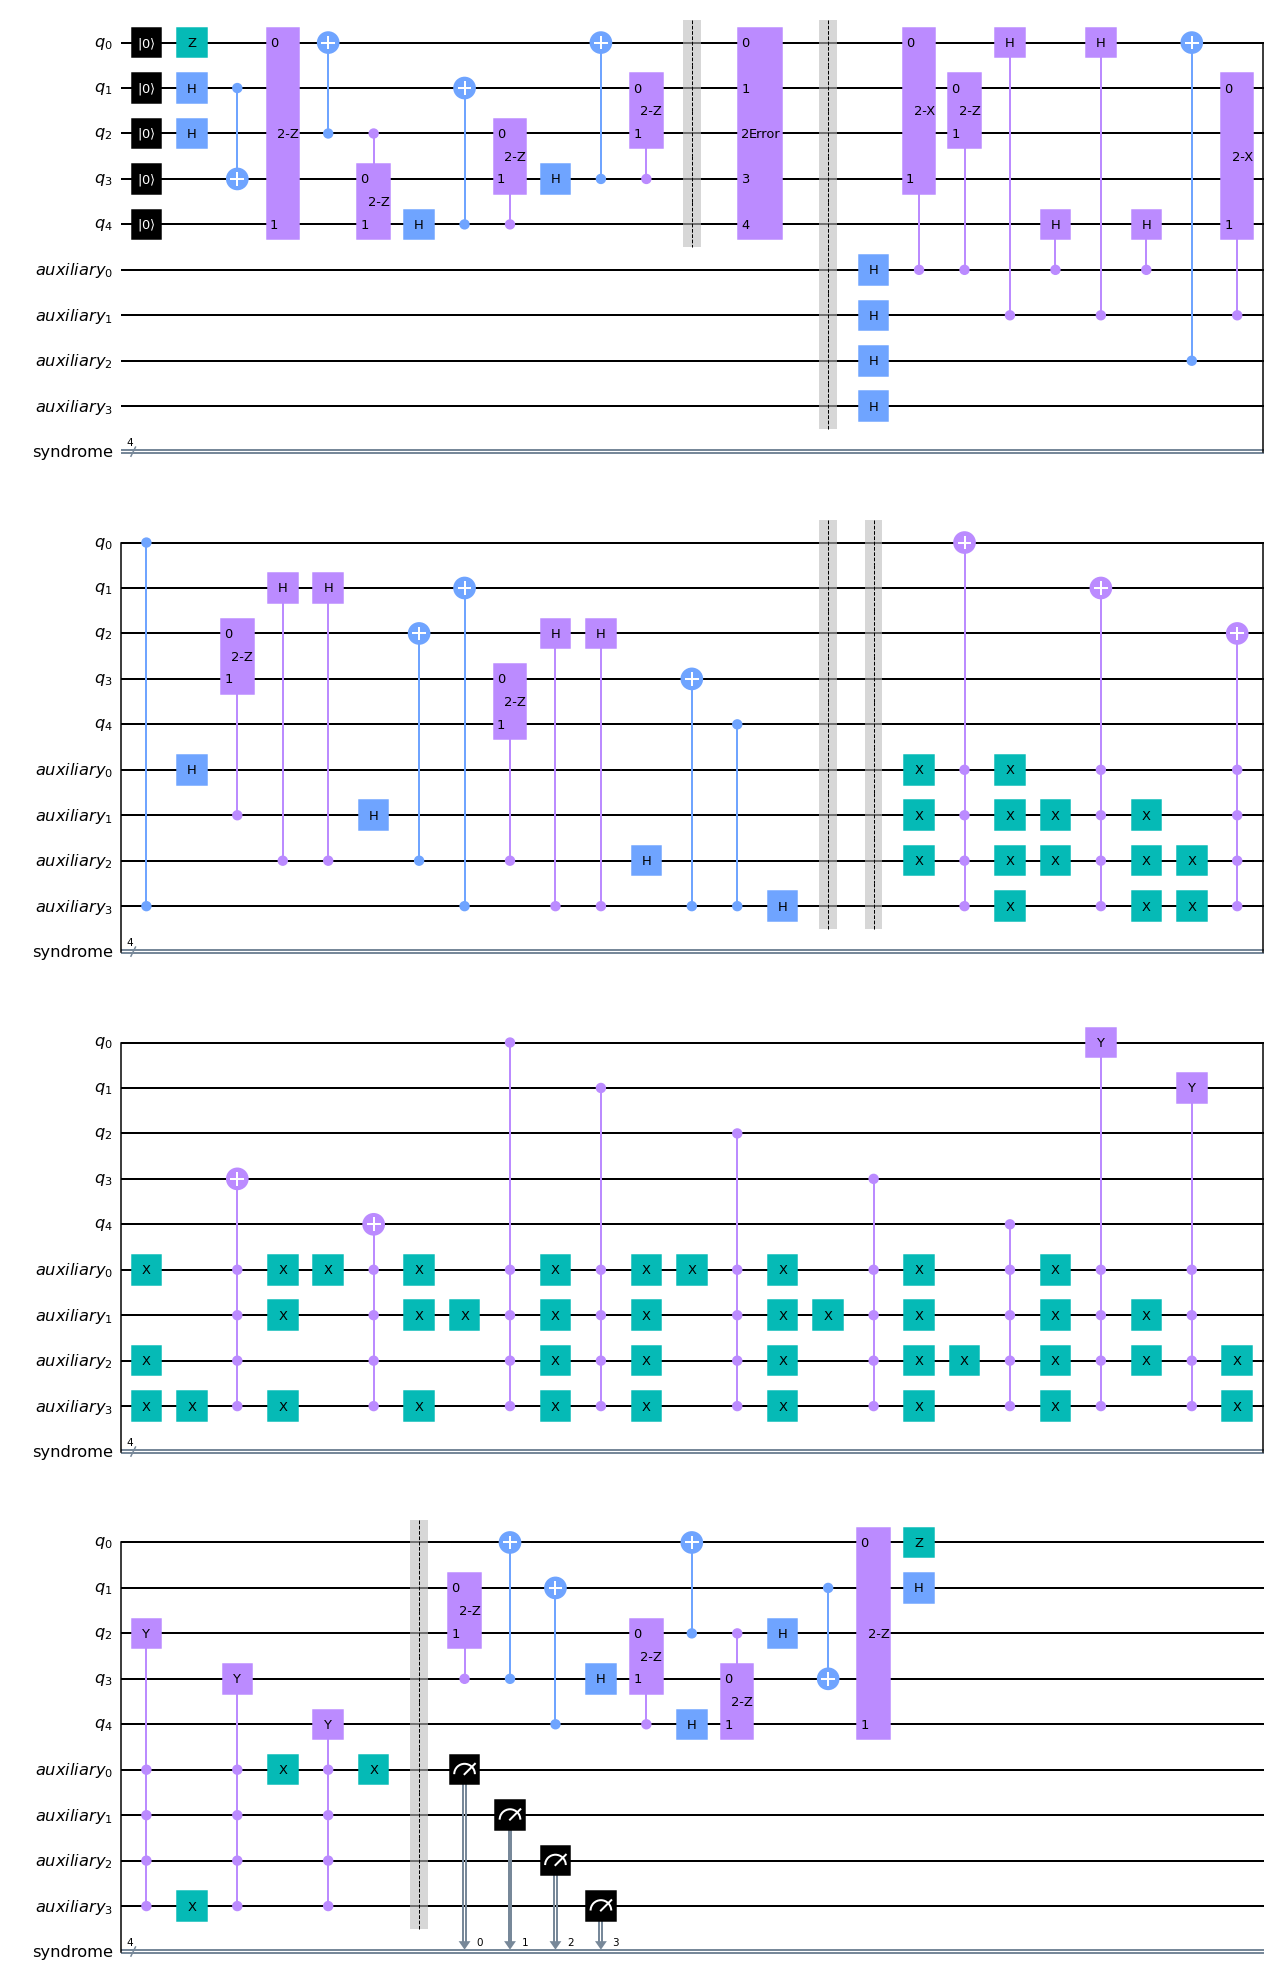

In [ ]:
# decoding
cz2 = MCMT('cz', 1, 2)

qc_5q.compose(cz2, qubits=[3, 1, 2], inplace=True)
qc_5q.cx(3, 0)
qc_5q.h(3)

qc_5q.cx(4, 1)
qc_5q.compose(cz2, qubits=[4, 2, 3], inplace=True)
qc_5q.h(4)

qc_5q.cx(2, 0)
qc_5q.compose(cz2, qubits=[2, 3, 4], inplace=True)
qc_5q.h(2)

qc_5q.cx(1, 3)
qc_5q.compose(cz2, qubits=[1, 0, 4], inplace=True)
qc_5q.z(0)
qc_5q.h(1)

qc_5q.draw('mpl')

In [ ]:
qc_5q_trans = transpile(qc_5q, sim)
syndrome = sim.run(qc_5q_trans, shots=1, memory=True).result().get_memory()
print(syndrome)

['0110']


In [ ]:
print(which_qubit)

3
